In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, clear_output
import time  

import requests
from bs4 import BeautifulSoup

import calendar
import datetime
import urllib.request
import re
import sys
import pickle
import os.path
import scipy.misc

class election():
    '''Class to create and display a state map based on colors.'''
    
    def __init__(self, results = []):
        if results == []:
            results = election.poll()
        self.img =  scipy.misc.imread('state_labels2.png')
        #np.load('state_labels2.npy')
        self.img = self.img[:,:,0]
        self.states = election.stateList()
        self.votes = election.electorate()
        if results != []:
            self.majority_wins(results)
    
    def save_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        polldata = election.poll()
        pickle.dump( polldata, open( filename, "wb" ) )
    
    def load_poll(filename=""):
        if filename =="":
            filename=str(datetime.date.today())+".p"
        if(os.path.isfile(fname)):
            polldata= pickle.load( open( filename, "rb" ) )
        return(polldata)
        
    def poll_ratings(fname='pollster-ratings.csv'):
        '''
        From: https://github.com/fivethirtyeight
        indices are as follows:
        0:ID, 1:Pollster, 2:Polls, 3:Live Caller With Cellphones, 4:Internet,
        5:NCPP/AAPOR/Roper, 6:Polls, 7:Simple Average Error, 8:Races Called Correctly,
        9:Advanced Plus-Minus, 10:Predictive Plus-Minus, 11:538 Grade, 
        12:Banned by 538, 13:Mean-Reverted Bias
        '''
        pollster_ratings = {}
        if os.path.isfile(fname):
            f = open(fname,'r')
            for line in f:
                index = 0
                for word in line.split(','):
                    if word=='ID':
                        break
                    if index==1:
                        poll = word
                    if index==7:
                        pollster_ratings[poll]=word
                        break
                    index+=1
        else:
            print("Pollster-rating file not found. Using defaults (10)")
        return pollster_ratings
    
    def poll(default_rating=10):
        all_states={}
        us_state_abbrev = election.getAbbrev()
        pollster_ratings = election.poll_ratings()
        today = datetime.date.today()
        one_day = datetime.timedelta(days=1)

        yesterday = today - one_day
        two_days_back = yesterday - one_day

        get_today =  calendar.month_name[today.month] + " " + str(today.day)
        get_day =  calendar.month_name[yesterday.month] + " " + str(yesterday.day)
        prev_get_day =  calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)

        url_contents = str(urllib.request.urlopen("http://www.realclearpolitics.com/epolls/latest_polls/state/").read())
        for i in range(36):
            first_pos = url_contents.find(get_day)
            second_pos = url_contents.find(prev_get_day)

            while second_pos < 0:
                two_days_back -= one_day
                prev_get_day = calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)
                second_pos = url_contents.find(prev_get_day)

            chunk = first_pos = url_contents[first_pos:second_pos]

            pattern = re.compile('(<a .*?(Clinton \+[\d]{1,2}|Trump \+[\d]{1,2}))')

            bits = re.findall( pattern, chunk )

            for bit in bits:
                new_bit = bit[0].replace( "http:", "" )
                new_bit = new_bit.replace( "https:", "" )
                pattern = re.compile( '([A-Z].*?:)' )
                election_type = re.findall( pattern, new_bit )
                if( election_type[0] == "General Election:" ):
                    election_type = "Gen"
                elif( not election_type[0][:-1] in us_state_abbrev ):
                    election_type = election_type[0][:3]
                    continue
                else:
                    election_type = us_state_abbrev.get(election_type[0][:-1])

                start = bit[0].find("http")
                find_poll = bit[0][start:start+200]
                poll_start = find_poll.find(">")
                poll_end = find_poll.find("<")
                pollster = find_poll[poll_start+1:poll_end]
                
                #Set default error to 10
                poll_err = default_rating
                for each in pollster_ratings:
                    if each.find(pollster) > -1 or pollster.find(each) > -1:
                        poll_err = float(pollster_ratings[each])

                pattern = re.compile( '(class="lp-poll.*?</a>)' )
                bits = re.findall( pattern, bit [0] )
                poll_chunk = bits[0][20:]
                first_pos = poll_chunk.find(">")
                poll_chunk = poll_chunk[first_pos+1:-4]

                split_result = bit[1].split(" ")
                perc1 = bit[0][0:-15].find(">Clinton")
                if perc1 < 0:
                    perc1 = bit[0][0:-15].find(">Trump")
                    scoreT = float(bit[0][perc1+7:perc1+9])
                    scoreC = float(bit[0][perc1+19:perc1+21])
                else:
                    scoreT = float(bit[0][perc1+19:perc1+21])
                    scoreC = float(bit[0][perc1+9:perc1+11])


                result = split_result[0][:2] + split_result[1]

                my_date = get_day[len(get_day)-2:len(get_day)]
                if my_date[0] == ' ':
                    my_date = '0' + my_date[1:3]

                if election_type not in all_states:
                    all_states[election_type] = (scoreC, scoreT, (time.strptime(get_day,"%B %d")).tm_yday,poll_err)          

            yesterday -= one_day
            two_days_back -= one_day

            get_day = calendar.month_name[yesterday.month] + " " + str(yesterday.day)
            prev_get_day =  calendar.month_name[two_days_back.month] + " " + str(two_days_back.day)

        return all_states
        
    def getAbbrev():
        us_state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'District of Columbia': 'DC',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
        }
        return us_state_abbrev
    
    def getnames():
        abbrev = election.getAbbrev()
        names = {}
        for key in abbrev:
            names[abbrev[key]] = key
        return names
    
    #Default eleciton results (used for testing) as randomly picked using out of date polling data.
    def polldefaults():
        defaults = {
            'WA':(1,0),
            'OR':(1,0),
            'CA':(1,0),
            'NV':(1,0),
            'AK':(0,1),
            'ID':(0,1),
            'UT':(0,1),
            'AZ':(0,1),
            'MT':(0,1),
            'WY':(0,1),
            'CO':(1,0),
            'NM':(1,0),
            'HI':(1,0),
            'ND':(0,1),
            'SD':(0,1),
            'NE':(0,1),
            'KS':(0,1),
            'OK':(0,1),
            'TX':(0,1),
            'MN':(1,0),
            'IA':(1,0),
            'MO':(0,1),
            'AR':(0,1),
            'LA':(0,1),
            'WI':(1,0),
            'IL':(1,0),
            'MS':(0,1),
            'IN':(0,1),
            'KY':(0,1),
            'TN':(0,1),
            'AL':(0,1),
            'MI':(1,0),
            'OH':(1,0),
            'GA':(0,1),
            'FL':(1,0),
            'SC':(0,1),
            'NC':(1,0),
            'VA':(1,0),
            'WV':(0,1),
            'MD':(1,0),
            'DE':(1,0),
            'NJ':(1,0),
            'RI':(1,0),
            'MA':(1,0),
            'ME':(1,0),
            'NH':(1,0),
            'VT':(1,0),
            'NY':(1,0),
            'PA':(1,0),
            'CT':(1,0)
        }
        return defaults
    
    def electorate():
        votes = {}
        #Sets of dictionaries to be used with dictionaryLabelStates()
        votes['AL'] = 9
        votes['AK'] = 3
        votes['AZ'] = 11
        votes['AR'] = 6
        votes['CA'] = 55
        votes['CO'] = 9
        votes['CT'] = 7
        votes['DC'] = 3
        votes['DE'] = 3
        votes['FL'] = 29
        votes['GA'] = 16
        votes['HI'] = 4 
        votes['ID'] = 4
        votes['IL'] = 20
        votes['IN'] = 11
        votes['IA'] = 6
        votes['KS'] = 6
        votes['KY'] = 8
        votes['LA'] = 8 
        votes['ME'] = 4
        votes['MD'] = 10 
        votes['MA'] = 11
        votes['MI'] = 16
        votes['MN'] = 10
        votes['MS'] = 6
        votes['MO'] = 10
        votes['MT'] = 3
        votes['NE'] = 5
        votes['NV'] = 6
        votes['NH'] = 4
        votes['NJ'] = 14
        votes['NM'] = 5
        votes['NY'] = 29 
        votes['NC'] = 15
        votes['ND'] = 3
        votes['OH'] = 18
        votes['OK'] = 7
        votes['OR'] = 7
        votes['PA'] = 20
        votes['RI'] = 4
        votes['SC'] = 9
        votes['SD'] = 3
        votes['TN'] = 11
        votes['TX'] = 38
        votes['UT'] = 6
        votes['VT'] = 3
        votes['VA'] = 13
        votes['WA'] = 12
        votes['WV'] = 5
        votes['WI'] = 10
        votes['WY'] = 3
        return votes    
    
    def stateList():
        states ={}
        states['AK']=0
        states['AL']=1
        states['AR']=2
        states['AZ']=3
        states['CA']=4
        states['CO']=5
        states['CT']=6
        states['DC']=7
        states['DE']=8
        states['FL']=9
        states['GA']=10
        states['HI']=11
        states['IA']=12
        states['ID']=13
        states['IL']=14
        states['IN']=15
        states['KS']=16
        states['KY']=17
        states['LA']=18
        states['MA']=19
        states['MD']=20
        states['ME']=21
        states['MI']=22
        states['MN']=23
        states['MO']=24
        states['MS']=25
        states['MT']=26
        states['NC']=27
        states['ND']=28
        states['NE']=29
        states['NH']=30
        states['NJ']=31
        states['NM']=32
        states['NV']=33
        states['NY']=34
        states['OH']=35
        states['OK']=36
        states['OR']=37
        states['PA']=38
        states['RI']=39
        states['SC']=40
        states['SD']=41
        states['TN']=42
        states['TX']=43
        states['UT']=44
        states['VA']=45
        states['VT']=46
        states['WA']=47
        states['WI']=48
        states['WV']=49
        states['WY']=50
        states['border']=255
        return states
   
    def majority_wins(self,results):
        red_blue = np.zeros( (self.img.shape[0], self.img.shape[1], 3) )
        red_blue[self.img > 50,:] = [0.5,0.5,0.5]
        red_blue[self.img < 50,:] = [0.5,0.5,0.5]
        red_blue[self.img == self.states['border'],:] = [1,1,1]
        red = 0
        blue = 0
        for state in election.electorate():
            if state in results:
                polldata = results[state]
                if polldata[0] > polldata[1]:
                    blue = blue + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0,0,1]
                elif polldata[1] > polldata[0]:
                    red = red + self.votes[state]
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [1,0,0]
                else:                       
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
            else:
                if state in self.states:
                    region = self.states[state]
                    test = self.img == region
                    red_blue[test,:] = [0.5,0.5,0.5]
                        
        plt.figure(figsize = (10,20))
        plt.imshow(red_blue)
        plt.axis('off')
        if(red > 270):
            plt.title("Red Wins: "+str(red)+"/"+str(blue))
        elif(blue > 270):
            plt.title("Blue Wins: "+str(blue)+"/"+str(red))
        else:
            plt.title("No clear winner, Blue: "+str(blue)+" Red:"+str(red)+" --- 270 votes needed")
        return red_blue
    
    def disp_state_movie(self):
        fig, ax = plt.subplots(figsize=(10,5))
        for state in self.states:
            print(state)
            #for region in self.states[state]:
            plt.imshow(self.img == self.states[state])
            plt.title(state)

            # Animaiton part (dosn't change)
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(2)      # Sleep for a fraction of a second to allow animation to catch up

    def get_unemployment_data():
        '''Obtaining data from the Bureau for Labor Statistics. The data 
        contained is a list of states, partnered with a tuple contianing
        four floating points. The floating point values correspond to, in 
        order, the states unemployment rate from Sept. 2015, the states
        unemployment rate from Sept. 2016, the difference between the two
        unemployment rates, and the rank of the overall change in employment
        for each state.
        '''

        # Obtaining data from the website, making it easier to use
        r = requests.get('http://www.bls.gov/web/laus/laumstch.htm').text
        soup = BeautifulSoup(r, 'lxml')
        text = soup.get_text()
        lines = text.split('\n')
        useful_lines = lines[530:-109]

        # These will store the data obtained from the BLS
        data = {}
        states = []

        # Adding each state to a list
        for line in useful_lines:
             if len(line) > 3 and '.' not in line:
                states.append(line)

        # Adding the data to the database for each state
        for line in useful_lines:
            for state in states:
                index = useful_lines.index(line)
                if state in line:
                    data[state] = tuple(useful_lines[index+1:index+5])

        # Changing Dictionary keys to state Abbreviations            
        for state in states:
            abbrevs = election.getAbbrev()
            newkey = abbrevs[state]
            data[newkey] = data.pop(state)

        return data
    
    def apply_unemployment_data(data, poll_dictionary):
        '''Using the data we found to adjust our prediction.'''
        
        for state in poll_dictionary:
            clinton, trump, date, stddev = poll_dictionary[state]
        
            change = float(data[state][2])
            clinton += change
            trump -= change
            
            poll_dictionary[state] = (clinton,trump,date,stddev)

In [3]:
poll = election.poll()
election.get_unemployment_data()


{'AK': ('6.5', '6.9', '0.4', '43'),
 'AL': ('6.1', '5.4', '-0.7', '8'),
 'AR': ('5.0', '4.0', '-1.0', '2'),
 'AZ': ('5.9', '5.5', '-0.4', '16'),
 'CA': ('6.0', '5.5', '-0.5', '12'),
 'CO': ('3.6', '3.6', '0.0', '31'),
 'CT': ('5.3', '5.4', '0.1', '35'),
 'DC': ('6.7', '6.1', '-0.6', '9'),
 'DE': ('4.9', '4.3', '-0.6', '9'),
 'FL': ('5.1', '4.7', '-0.4', '16'),
 'GA': ('5.6', '5.1', '-0.5', '12'),
 'HI': ('3.4', '3.3', '-0.1', '27'),
 'IA': ('3.6', '4.2', '0.6', '47'),
 'ID': ('4.1', '3.8', '-0.3', '23'),
 'IL': ('5.9', '5.5', '-0.4', '16'),
 'IN': ('4.5', '4.5', '0.0', '31'),
 'KS': ('4.0', '4.4', '0.4', '43'),
 'KY': ('5.4', '5.0', '-0.4', '16'),
 'LA': ('6.0', '6.4', '0.4', '43'),
 'MA': ('4.8', '3.6', '-1.2', '1'),
 'MD': ('5.1', '4.2', '-0.9', '5'),
 'ME': ('4.2', '4.1', '-0.1', '27'),
 'MI': ('5.1', '4.6', '-0.5', '12'),
 'MN': ('3.6', '4.0', '0.4', '43'),
 'MO': ('4.6', '5.2', '0.6', '47'),
 'MS': ('6.4', '6.0', '-0.4', '16'),
 'MT': ('4.1', '4.3', '0.2', '37'),
 'NC': ('5.7', '4

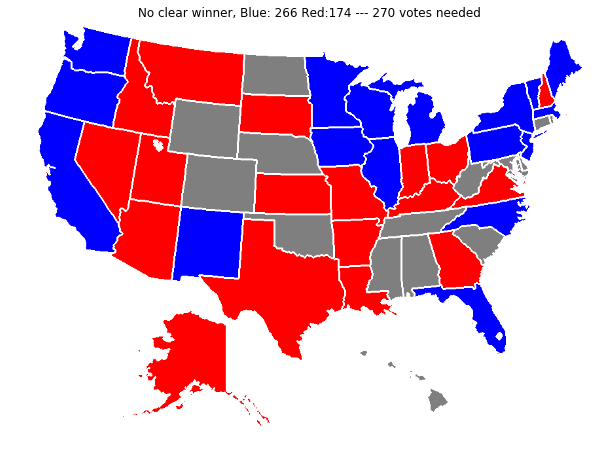

In [57]:
poll = election.poll()
data = election.get_unemployment_data()
election.apply_unemployment_data(data,poll)
election(poll)